In [1]:
import pandas as pd
import wrds
import config
from datetime import datetime
import unittest
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import Table03Load
from Table03Load import quarter_to_date, date_to_quarter
import Table03Analysis
import Table02Prep
import warnings
warnings.filterwarnings("ignore")

"""
Reads in manual dataset for primary dealers and holding companies and matches it with linkhist entry for company. 
Calculates the market capital ratio, book capital ratio, and AEM leverage ratio and the correlation of these ratios with macroeconomic variables.
Compiles and prepares this data to produce Table 03 from intermediary asset pricing paper in LaTeX format.
Also creates a summary statistics table and figure in LaTeX format.
"""

def get_gvkey():

    prim_dealers = pd.read_csv('../data/ticks_V3.csv').dropna()
    prim_dealers['gvkey'] = prim_dealers['gvkey'].astype(int).astype(str).str.zfill(6)

    raw_ticks = pd.read_csv('../data/manual/match_RSSD_ID.csv')
    raw_ticks['Start Date'] = pd.to_datetime(raw_ticks['Start Date'])
    raw_ticks['Start Date']   = raw_ticks['Start Date'].dt.strftime('%Y-%m-%d')
    raw_ticks['End Date'] = pd.to_datetime(raw_ticks['End Date'], errors='coerce')
    raw_ticks['End Date'] = raw_ticks['End Date'].fillna(pd.to_datetime('2025-03-09'))
    raw_ticks['End Date'] = raw_ticks['End Date'].dt.strftime('%Y-%m-%d')
    prim_dealers = prim_dealers.merge(raw_ticks, on='Primary Dealer')
    return prim_dealers

def combine_bd_financials(UPDATED=False):
    """
    Combine broker & dealer financial data from historical sources and, if UPDATED, from more recent FRED data.
    """
    
    # Load historical data (up to 2012) from local file or fetch if necessary
    bd_financials_historical = Table03Load.load_fred_past()
    bd_financials_historical.index = pd.to_datetime(bd_financials_historical.index)
    
    if UPDATED:
        # Load recent data
        bd_financials_recent = Table03Load.load_bd_financials()  
        bd_financials_recent.index = pd.to_datetime(bd_financials_recent.index)
        start_date = pd.to_datetime("2012-12-31")
        bd_financials_recent = bd_financials_recent[bd_financials_recent.index > start_date]

        # Append the recent data to the historical data
        bd_financials_combined = pd.concat([bd_financials_historical, bd_financials_recent])
        
    else:
        bd_financials_combined = bd_financials_historical
    
    return bd_financials_combined    


def prep_dataset(dataset, UPDATED=False):
    """
    Function to prepare datasets by dropping duplicates, converting quarter to date, 
    and aggregating data based on specified columns.
    """
    # Drop duplicates and convert 'datafqtr' to date format
    dataset = dataset.drop_duplicates()
    dataset['datafqtr'] = dataset['datafqtr'].apply(quarter_to_date)
    
    # Aggregate data based on specified columns
    aggregated_dataset = dataset.groupby('datafqtr').agg({
        'total_assets': 'sum',
        'book_debt': 'sum',
        'book_equity': 'sum',
        'market_equity': 'sum'
    }).reset_index()
    
    bd_financials_combined = combine_bd_financials(UPDATED=UPDATED)
    aggregated_dataset = aggregated_dataset.merge(bd_financials_combined, left_on='datafqtr', right_index=True)

    return aggregated_dataset


def calculate_ratios(data):
    """
    Calculates market cap ratio, book cap ratio, and AEM leverage ratio.
    """
    data['market_cap_ratio'] = data['market_equity'] / (data['book_debt'] + data['market_equity'])
    data['book_cap_ratio'] = data['book_equity'] / (data['book_debt'] + data['book_equity'])
    data['aem_leverage_ratio'] = data['bd_fin_assets'] / (data['bd_fin_assets'] - data['bd_liabilities'])
    # data['aem_leverage_ratio'] = 1 / data['aem_leverage']
    
    return data


def aggregate_ratios(data):
    """
    Aggregates market cap ratio, book cap ratio, and AEM leverage ratio.
    """
    data = calculate_ratios(data)
    data = data[['datafqtr', 'market_cap_ratio', 'book_cap_ratio', 'aem_leverage_ratio']]
    data.rename(columns={'datafqtr': 'date'}, inplace=True)
    data = data.set_index('date')
    return data


def convert_ratios_to_factors(data):
    """
    Converts ratios to analytical factors.
    """

    factors_df = pd.DataFrame(index=data.index)

    # AR(1) with constant for market capital ratio
    cleaned_data = data['market_cap_ratio'].dropna()
    model = AutoReg(cleaned_data, lags=1, trend='c')
    model_fitted = model.fit()
    factors_df['innovations_mkt_cap'] = model_fitted.resid
    factors_df['market_capital_factor'] = factors_df['innovations_mkt_cap'] / data['market_cap_ratio'].shift(1)
    factors_df.drop(columns=['innovations_mkt_cap'], inplace=True)

    # AR(1) with constant for market capital ratio
    cleaned_data = data['book_cap_ratio'].dropna()
    model = AutoReg(cleaned_data, lags=1, trend='c')
    model_fitted = model.fit()
    factors_df['innovations_book_cap'] = model_fitted.resid
    factors_df['book_capital_factor'] = factors_df['innovations_book_cap'] / data['book_cap_ratio'].shift(1)
    factors_df.drop(columns=['innovations_book_cap'], inplace=True)

    # Calculate the AEM leverage factor

    # factors_df['leverage_growth'] = data['aem_leverage_ratio'].pct_change().fillna(0)
    # decomposition = seasonal_decompose(factors_df['leverage_growth'], model='additive', period=4)
    # factors_df['seasonal'] = decomposition.seasonal
    # factors_df['aem_leverage_factor'] = factors_df['leverage_growth'] - factors_df['seasonal']
    df = data.copy()[['aem_leverage_ratio']]
    df['ln_leverage'] = np.log(df['aem_leverage_ratio'])
    df['dl_leverage'] = df['ln_leverage'].diff()  # Δln(Leverage)

    # Construct Quanterly dummy variable
    df['quarter'] = df.index.quarter  # 1,2,3,4
    df['Q2'] = (df['quarter'] == 2).astype(int)
    df['Q3'] = (df['quarter'] == 3).astype(int)
    df['Q4'] = (df['quarter'] == 4).astype(int)
    df['aem_leverage_factor'] = np.nan

    # real time regression up to current time
    for i in range(len(df)):
        if i == 0:
            continue
        subdf = df.iloc[:i+1].dropna(subset=['dl_leverage'])
        if len(subdf) < 10:
            continue

        # regression: dl_leverage ~ c + Q2 + Q3 + Q4
        X = subdf[['Q2', 'Q3', 'Q4']]
        X = sm.add_constant(X)
        y = subdf['dl_leverage']
        model = sm.OLS(y, X).fit()

        # predict
        current_index = subdf.index[-1]  
        row_t = subdf.loc[current_index]
        X_t = [1, row_t['Q2'], row_t['Q3'], row_t['Q4']]
        yhat_t = model.predict([X_t])[0]
        resid_t = row_t['dl_leverage'] - yhat_t
        df.at[current_index, 'aem_leverage_factor'] = resid_t
        
    # Return only the factor columns
    factors_df['aem_leverage_factor'] = df['aem_leverage_factor']
    factors_df = factors_df.dropna()

    # Return only the factor columns
    return factors_df[['market_capital_factor', 'book_capital_factor', 'aem_leverage_factor']]


def calculate_ep(shiller_cape):
    """
    Processes the Shiller CAPE DataFrame and calculates the E/P ratio.
    """
    df = shiller_cape.copy()
    df.columns = ['date', 'cape']
    df['date'] = df['date'].astype(str)
    df['date'] = pd.to_datetime(df['date'], format='%Y.%m') + pd.offsets.MonthEnd(0)
    df = df.set_index('date')
    df['e/p'] = 1 / df['cape']
    
    return df


def macro_variables(db):
    """
    Creates a table of macroeconomic variables to be used in the analysis.
    Note: The function starts gathering data from one year earlier than 1970 to allow for factor calculation where differences are used.
    """
    # Load FRED macroeconomic data and resample quarterly
    macro_data = Table03Load.load_fred_macro_data()
    macro_data = macro_data.rename(columns={'UNRATE': 'unemp_rate',
                                    'NFCI': 'nfci',
                                    'GDPC1': 'real_gdp',
                                    'A191RL1Q225SBEA': 'real_gdp_growth',
                                    })
    macro_data.index = pd.to_datetime(macro_data.index)
    macro_data.rename(columns={'DATE': 'date'}, inplace=True)
    macro_quarterly = macro_data.resample('Q').mean()

    # Load Shiller PE and calculate earnings-to-price ratio
    shiller_cape = Table03Load.load_shiller_pe()
    shiller_ep = calculate_ep(shiller_cape)
    shiller_quarterly = shiller_ep.resample('Q').mean()

    # Fetch Fama-French factors and resample quarterly
    ff_facs = Table03Load.fetch_ff_factors(start_date='19690101', end_date='20240229')
    ff_facs_quarterly = ff_facs.to_timestamp(freq='M').resample('Q').last()

    # Pull CRSP Value Weighted Index and calculate quarterly market volatility
    # value_wtd_indx = Table03Load.pull_CRSP_Value_Weighted_Index(db)
    sql_query = """
    SELECT date, vwretd
    FROM crsp.dsi as dsi
    WHERE dsi.date >= '1969-01-01' AND dsi.date <= '2024-02-29'
    """
    value_wtd_indx = db.raw_sql(sql_query, date_cols=["date"])
    value_wtd_indx['date'] = pd.to_datetime(value_wtd_indx['date'])
    # annual_vol_quarterly = value_wtd_indx.set_index('date')['vwretd'].pct_change().groupby(pd.Grouper(freq='Q')).std().rename('mkt_vol')
    annual_vol_quarterly = value_wtd_indx.set_index('date')['vwretd'].groupby(pd.Grouper(freq='Q')).std().rename('mkt_vol')

    # Merge all macroeconomic data
    macro_merged = shiller_quarterly.merge(macro_quarterly, left_index=True, right_index=True, how='left')
    macro_merged = macro_merged.merge(ff_facs_quarterly[['mkt_ret']],left_index=True, right_index=True)
    macro_merged = macro_merged.merge(annual_vol_quarterly, left_index=True, right_index=True)

    return macro_merged


def create_panelA(ratios, macro):
    """
    Creates Panel A of Table 3.    
    """
    ratios_renamed = ratios.rename(columns={
        'market_cap_ratio': 'Market capital',
        'book_cap_ratio': 'Book capital',
        'aem_leverage_ratio': 'AEM leverage'
    })

    macro = macro[['e/p', 'unemp_rate', 'nfci', 'real_gdp', 'mkt_ret', 'mkt_vol']]
    macro_renamed = macro.rename(columns={
        'e/p': 'E/P',
        'unemp_rate': 'Unemployment',
        'nfci': 'Financial conditions',
        'real_gdp': 'GDP',
        'mkt_ret': 'Market excess return',
        'mkt_vol': 'Market volatility'
    })

    panelA = ratios_renamed.merge(macro_renamed, left_index=True, right_index=True)
    ordered_columns= ['Market capital', 'Book capital', 'AEM leverage',
                        'E/P', 'Unemployment', 'Financial conditions', 'GDP', 'Market excess return', 'Market volatility']
    panelA = panelA[ordered_columns]
    panelA = panelA.loc['1970-01-01':]
    
    return panelA


def create_panelB(factors, macro):
    """
    Creates Panel B of Table 3.
    """
    factors_renamed = factors.rename(columns={
        'market_capital_factor': 'Market capital factor',
        'book_capital_factor': 'Book capital factor',
        'aem_leverage_factor': 'AEM leverage factor'})
    
    # Calculate quarterly growth rates of macroeconomic variables
    macro_growth = np.log(macro / macro.shift(1))
    macro_growth = macro_growth.fillna(0)
    macro_growth = macro_growth.loc['1970-01-01':]

    macro_growth['mkt_ret'] = macro['mkt_ret']
    macro_growth_renamed = macro_growth.rename(columns={
        'e/p': 'E/P growth',
        'unemp_rate': 'Unemployment growth',
        'nfci': 'Financial conditions growth',
        'real_gdp': 'GDP growth',
        'mkt_ret': 'Market excess return',
        'mkt_vol': 'Market volatility growth'
    })

    panelB = factors_renamed.merge(macro_growth_renamed, left_index=True, right_index=True)
    ordered_columns = ['Market capital factor', 'Book capital factor', 'AEM leverage factor',
                       'E/P growth', 'Unemployment growth', 'Financial conditions growth', 'GDP growth', 'Market excess return', 'Market volatility growth']
    panelB = panelB[ordered_columns]
    panelB = panelB.loc['1970-01-01':]  

    return panelB                      


def format_correlation_matrix(corr_matrix):
    """
    Formats the correlation matrix by masking the lower triangle.
    """
    corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=0).astype(np.bool_))
    return corr_matrix


def calculate_correlation_panelA(panelA):
    """
    Calculates the correlation for Panel A (capital ratio levels).
    """
    correlation_panelA = format_correlation_matrix(panelA.iloc[:, :3].corr())
    main_cols = panelA[['Market capital', 'Book capital', 'AEM leverage']]
    other_cols = panelA[['E/P', 'Unemployment', 'GDP', 'Financial conditions', 'Market volatility']]
    
    correlation_results_panelA = pd.DataFrame(index=main_cols.columns)
    for column in other_cols.columns:
        correlation_results_panelA[column] = main_cols.corrwith(other_cols[column])
    
    return pd.concat([correlation_panelA, correlation_results_panelA.T], axis=0)


def calculate_correlation_panelB(panelB):
    """
    Calculates the correlation for Panel B (capital ratio factors).
    """
    correlation_panelB = format_correlation_matrix(panelB.iloc[:, :3].corr())
    main_cols = panelB[['Market capital factor', 'Book capital factor', 'AEM leverage factor']]
    other_cols = panelB[['Market excess return', 'E/P growth', 'Unemployment growth', 'GDP growth', 'Financial conditions growth', 'Market volatility growth']]
    
    correlation_results_panelB = pd.DataFrame(index=main_cols.columns)
    for column in other_cols.columns:
        correlation_results_panelB[column] = main_cols.corrwith(other_cols[column])
    
    return pd.concat([correlation_panelB, correlation_results_panelB.T], axis=0)


def format_final_table(corrA, corrB):
    """
    Format the final correlation table.
    """
    panelB_renamed = corrB.copy()
    panelB_renamed.columns = corrA.columns

    panelB_column_names = pd.DataFrame([corrB.columns], columns=corrA.columns)
    panelB_column_names.reset_index(drop=True, inplace=True)
    panelB_combined = pd.concat([panelB_column_names, panelB_renamed])

    panelA_title = pd.DataFrame({'Panel A: Correlations of levels': [np.nan, np.nan, np.nan]}, index=corrA.columns)
    panelB_title = pd.DataFrame({'Panel B: Correlations of factors': [np.nan, np.nan, np.nan]}, index=corrA.columns)
    
    full_table = pd.concat([panelA_title.T, corrA, panelB_title.T, panelB_combined])

    return full_table


def convert_and_export_tables_to_latex(corrA, corrB, UPDATED=False):
    """
    Convert correlation tables to LaTeX format and export to a .tex file.
    """
    # Fill NaN values with empty strings for both tables    
    corrA = corrA.round(2).fillna('')
    corrB = corrB.round(2).fillna('')
    
    # Define the caption based on whether the table is updated or not
    if UPDATED:
        caption = "Updated"
    else:
        caption = "Original"

    # Convert the correlation tables to LaTeX format without using to_latex() directly to control the structure
    # Define the column format and titles manually
    column_format = 'l' + 'c' * (len(corrA.columns))
    header_row = " & " + " & ".join(corrA.columns) + " \\\\"
    
    # Generate content rows for Panel A and B 
    panelA_rows = "\n".join([f"{index} & " + " & ".join(corrA.loc[index].astype(str)) + " \\\\" for index in corrA.index])
    panelB_rows = "\n".join([f"{index} & " + " & ".join(corrB.loc[index].astype(str)) + " \\\\" for index in corrB.index])
    
    full_latex = rf"""
    \begin{{table}}[htbp]
    \centering
    \caption{{\label{{tab:correlation}}{caption}}}
    \begin{{adjustbox}}{{max width=\textwidth}}
    \small
    \begin{{tabular}}{{{column_format}}}
        \toprule
        Panel A: Correlation of Levels \\
        \midrule
        {header_row}
        \midrule
        {panelA_rows}
        \midrule
        Panel B: Correlation of Factors \\
        \midrule
        {header_row}
        \midrule
        {panelB_rows}
        \bottomrule
    \end{{tabular}}
    \end{{adjustbox}}
    \end{{table}}
    """

    # Write the full LaTeX code to a .tex file
    if UPDATED:
        with open('../output/updated_table03.tex', 'w') as f:
            f.write(full_latex)
    else:
        with open('../output/table03.tex', 'w') as f:
            f.write(full_latex)


def main(UPDATED=False):
    """
    Main function to execute the entire data processing pipeline.
    """

    db = wrds.Connection(wrds_username=config.WRDS_USERNAME)
    
    # prim_dealers, _ = Table02Prep.prim_deal_merge_manual_data_w_linktable(UPDATED=UPDATED)
    prim_dealers = get_gvkey()
    dataset, _ = Table03Load.fetch_data_for_tickers(prim_dealers, db)
    prep_datast = prep_dataset(dataset, UPDATED=UPDATED)
    ratio_dataset = aggregate_ratios(prep_datast)
    factors_dataset = convert_ratios_to_factors(ratio_dataset)
    macro_dataset = macro_variables(db)
    panelA = create_panelA(ratio_dataset, macro_dataset)
    panelB = create_panelB(factors_dataset, macro_dataset)

    Table03Analysis.create_summary_stat_table_for_data(panelA, UPDATED=UPDATED)
    Table03Analysis.plot_figure02(ratio_dataset, UPDATED=UPDATED)

    correlation_panelA = calculate_correlation_panelA(panelA)
    correlation_panelB = calculate_correlation_panelB(panelB)
    formatted_table = format_final_table(correlation_panelA, correlation_panelB)
    convert_and_export_tables_to_latex(correlation_panelA, correlation_panelB, UPDATED=UPDATED)
    return print(formatted_table.style.format(na_rep=''))

Loading library list...
Done
Extracted ltab127d.prn to data\pulled\ltab127d.prn
Loaded data from cache.
Loading data from cache.
Table 03 has been created and exported to LaTeX format.


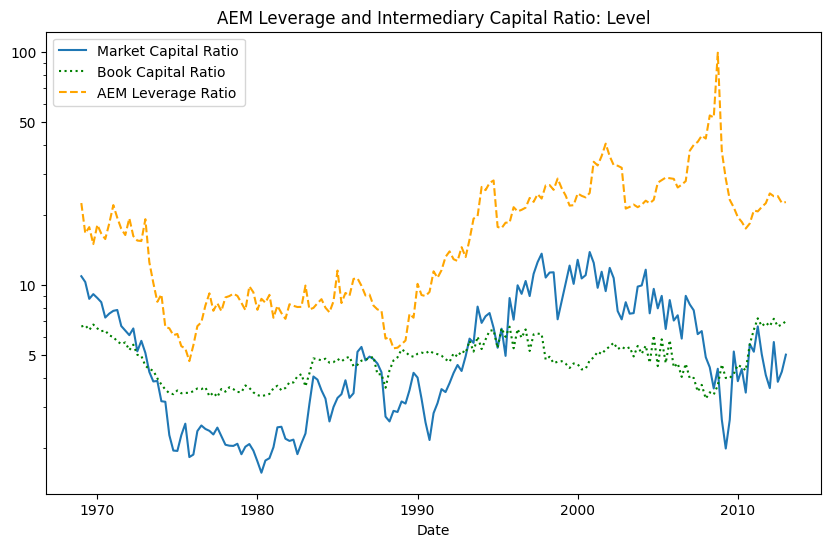

In [2]:
if __name__ == "__main__":
    main(UPDATED=False)
    print("Table 03 has been created and exported to LaTeX format.")

In [4]:
ratio_dataset

,market_cap_ratio,book_cap_ratio,aem_leverage_ratio
date,,,
1968-12-31,0.109091,0.066318,22.494532
1969-03-31,0.102999,0.067183,16.683790
1969-06-30,0.087212,0.064097,17.725951
1969-09-30,0.091390,0.067656,14.988372
1969-12-31,0.087972,0.065104,18.141343
...,...,...,...
2011-12-31,0.036085,0.066601,24.745237
2012-03-31,0.056910,0.071615,24.059559
2012-06-30,0.038399,0.066411,24.093422


In [217]:
def get_gvkey():

    prim_dealers = pd.read_csv('../data/ticks_V3.csv').dropna()
    prim_dealers['gvkey'] = prim_dealers['gvkey'].astype(int).astype(str).str.zfill(6)

    raw_ticks = pd.read_csv('../data/pulled/匹配RSSD_ID.csv')
    raw_ticks['Start Date'] = pd.to_datetime(raw_ticks['Start Date'])
    raw_ticks['Start Date']   = raw_ticks['Start Date'].dt.strftime('%Y-%m-%d')
    raw_ticks['End Date'] = pd.to_datetime(raw_ticks['End Date'], errors='coerce')
    raw_ticks['End Date'] = raw_ticks['End Date'].fillna(pd.to_datetime('2025-03-09'))
    raw_ticks['End Date'] = raw_ticks['End Date'].dt.strftime('%Y-%m-%d')
    prim_dealers = prim_dealers.merge(raw_ticks, on='Primary Dealer')
    return prim_dealers

get_gvkey()

,Primary Dealer,gvkey,Unnamed: 0,Start Date,End Date
0,"AUBREY G. LANSTON & CO., INC.",011687,0,1960-05-19,2000-04-17
1,CHEMICAL,002968,4,1960-05-19,1989-03-31
2,CHEMICAL,002968,4,1960-05-19,1989-03-31
3,DREXEL BURNHAM LAMBERT,144496,8,1960-05-19,1990-03-28
4,FIRST CHICAGO,144496,9,1960-05-19,1990-01-01
...,...,...,...,...,...
133,MF GLOBAL INC.,002014,160,2011-02-02,2011-10-31
134,"SG AMERICAS SECURITIES, LLC",002968,161,2011-02-02,2025-03-09
135,MORGAN STANLEY & CO. LLC,001494,162,2011-05-31,2025-03-09
136,"BANK OF NOVA SCOTIA, NEW YORK AGENCY",007647,163,2011-10-04,2025-03-09


In [60]:
db = wrds.Connection(wrds_username=config.WRDS_USERNAME)
UPDATED = False
# prim_dealers, _ = Table02Prep.prim_deal_merge_manual_data_w_linktable(UPDATED=UPDATED)
prim_dealers = get_gvkey()
dataset, _ = Table03Load.fetch_data_for_tickers(prim_dealers, db)
prep_datast = prep_dataset(dataset, UPDATED=UPDATED)
ratio_dataset = aggregate_ratios(prep_datast)
factors_dataset = convert_ratios_to_factors(ratio_dataset)
macro_dataset = macro_variables(db)
panelA = create_panelA(ratio_dataset, macro_dataset)
panelB = create_panelB(factors_dataset, macro_dataset)

Loading library list...
Done
Extracted ltab127d.prn to data\pulled\ltab127d.prn
Loaded data from cache.
Loading data from cache.


In [65]:
df = ratio_dataset.copy()[['aem_leverage_ratio']]
df['ln_leverage'] = np.log(df['aem_leverage_ratio'])
df['dl_leverage'] = df['ln_leverage'].diff()  # Δln(Leverage)

# Construct Quanterly dummy variable
df['quarter'] = df.index.quarter  # 1,2,3,4
df['Q2'] = (df['quarter'] == 2).astype(int)
df['Q3'] = (df['quarter'] == 3).astype(int)
df['Q4'] = (df['quarter'] == 4).astype(int)
df['aem_leverage_factor'] = np.nan
df

,aem_leverage_ratio,ln_leverage,dl_leverage,quarter,Q2,Q3,Q4,aem_leverage_factor
date,,,,,,,,
1968-12-31,22.494532,3.113272,NaN,4,0,0,1,NaN
1969-03-31,16.683790,2.814438,-0.298835,1,0,0,0,NaN
1969-06-30,17.725951,2.875030,0.060592,2,1,0,0,NaN
1969-09-30,14.988372,2.707275,-0.167755,3,0,1,0,NaN
1969-12-31,18.141343,2.898193,0.190919,4,0,0,1,NaN
...,...,...,...,...,...,...,...,...
2011-12-31,24.745237,3.208633,0.097035,4,0,0,1,NaN
2012-03-31,24.059559,3.180532,-0.028101,1,0,0,0,NaN
2012-06-30,24.093422,3.181939,0.001406,2,1,0,0,NaN


In [61]:
correlation_panelA = calculate_correlation_panelA(panelA)
correlation_panelB = calculate_correlation_panelB(panelB)
formatted_table = format_final_table(correlation_panelA, correlation_panelB)
formatted_table

,Market capital,Book capital,AEM leverage
Panel A: Correlations of levels,NaN,NaN,NaN
Market capital,1.0,0.501865,0.52471
Book capital,NaN,1.0,0.196753
AEM leverage,NaN,NaN,1.0
E/P,-0.779344,-0.534457,-0.630432
Unemployment,-0.55634,-0.045354,-0.340982
GDP,0.479522,0.350197,0.706515
Financial conditions,-0.499077,-0.48476,-0.262296
Market volatility,0.000752,-0.127053,0.325796
Panel B: Correlations of factors,NaN,NaN,NaN


In [47]:
factors_dataset = convert_ratios_to_factors(ratio_dataset)
factors_dataset

,market_capital_factor,book_capital_factor,aem_leverage_factor
date,,,
1971-06-30,-0.117934,-0.008865,-0.075231
1971-09-30,-0.025054,0.029941,-0.037166
1971-12-31,-0.028014,-0.057626,-0.012895
1972-03-31,0.081007,0.064114,-0.004572
1972-06-30,-0.185082,-0.081595,-0.007383
...,...,...,...
2011-12-31,-0.143681,-0.001839,0.061380
2012-03-31,0.539798,0.104673,0.030244
2012-06-30,-0.317646,-0.037853,-0.003130


In [49]:
macro_dataset

,cape,e/p,unemp_rate,nfci,real_gdp,real_gdp_growth,mkt_ret,mkt_vol
1969-03-31,20.185412,0.049685,3.400000,NaN,5283.597,6.4,0.0264,0.005781
1969-06-30,20.371403,0.049120,3.433333,NaN,5299.625,1.2,-0.0718,0.005469
1969-09-30,18.503090,0.054048,3.566667,NaN,5334.600,2.7,-0.0298,0.008571
1969-12-31,17.882345,0.055975,3.566667,NaN,5308.556,-1.9,-0.0263,0.006589
1970-03-31,16.264751,0.061616,4.166667,NaN,5300.652,-0.6,-0.0106,0.007303
...,...,...,...,...,...,...,...,...
2023-03-31,28.490441,0.035106,3.533333,-0.239282,22403.435,2.8,0.0251,0.010522
2023-06-30,29.155641,0.034311,3.533333,-0.225447,22539.418,2.4,0.0647,0.007412
2023-09-30,30.332030,0.032976,3.666667,-0.332111,22780.933,4.4,-0.0524,0.006837
2023-12-31,30.732768,0.032556,3.800000,-0.375739,22960.600,3.2,0.0487,0.008071


In [ ]:
def create_panelB(factors, macro):
    """
    Creates Panel B of Table 3.
    """
    factors_renamed = factors.rename(columns={
        'market_capital_factor': 'Market capital factor',
        'book_capital_factor': 'Book capital factor',
        'aem_leverage_factor': 'AEM leverage factor'})
    
    # Calculate quarterly growth rates of macroeconomic variables
    macro_growth = np.log(macro / macro.shift(1))
    macro_growth = macro_growth.fillna(0)
    macro_growth = macro_growth.loc['1970-01-01':]

    macro_growth['mkt_ret'] = macro['mkt_ret']
    macro_growth_renamed = macro_growth.rename(columns={
        'e/p': 'E/P growth',
        'unemp_rate': 'Unemployment growth',
        'nfci': 'Financial conditions growth',
        # 'real_gdp': 'GDP growth',
        'mkt_ret': 'Market excess return',
        'mkt_vol': 'Market volatility growth'
    })

    panelB = factors_renamed.merge(macro_growth_renamed, left_index=True, right_index=True)
    ordered_columns = ['Market capital factor', 'Book capital factor', 'AEM leverage factor',
                       'E/P growth', 'Unemployment growth', 'Financial conditions growth', 'GDP growth', 'Market excess return', 'Market volatility growth']
    panelB = panelB[ordered_columns]
    panelB = panelB.loc['1970-01-01':]  

    return panelB  

panelB

,Market capital factor,Book capital factor,AEM leverage factor,E/P growth,Unemployment growth,Financial conditions growth,GDP growth,Market excess return,Market volatility growth
1970-03-31,-0.005548,0.000904,-0.024828,0.096007,0.155485,0.000000,-0.001490,-0.0106,0.102867
1970-06-30,-0.108114,0.031234,-0.048252,0.113078,0.134531,0.000000,0.001416,-0.0579,0.670456
1970-09-30,0.064626,-0.020901,0.152937,0.019940,0.080580,0.000000,0.009172,0.0418,-0.504313
1970-12-31,0.053986,0.006455,0.150018,-0.080446,0.121361,0.000000,-0.010774,0.0572,-0.326654
1971-03-31,0.036855,-0.021662,-0.059085,-0.088430,0.016998,0.000000,0.026799,0.0413,-0.262096
...,...,...,...,...,...,...,...,...,...
2011-12-31,-0.143681,-0.001839,0.055095,0.013342,-0.041594,-2.554027,0.011168,0.0074,-0.191574
2012-03-31,0.539798,0.104673,0.030785,-0.058080,-0.043399,3.015620,0.008351,0.0311,-0.982825
2012-06-30,-0.317646,-0.037853,0.005474,0.027098,-0.008097,-0.149082,0.004453,0.0389,0.479335
2012-09-30,0.075987,0.048418,-0.081349,-0.014881,-0.020535,0.324443,0.001439,0.0273,-0.373170
